## 2D Model

In [235]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP,SaasPyroModel
from botorch.fit import fit_gpytorch_model
from botorch.fit import fit_fully_bayesian_model_nuts
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement, qUpperConfidenceBound
from botorch.acquisition.analytic import UpperConfidenceBound, ProbabilityOfImprovement
from botorch.optim import optimize_acqf
from botorch.cross_validation import gen_loo_cv_folds
from botorch.posteriors.gpytorch import GPyTorchPosterior
import math
import GPy

## Identify and plot the objective function

In [236]:
def F(X1,X2):
    return (1-(X1**2+X2**3))*np.exp(-(X1**2+X2**2)/2)

x1 = np.linspace(-3,3,101)
x2 = np.linspace(-3,3,101)
x1,x2 = np.meshgrid(x1,x2)
y = F(x1,x2)

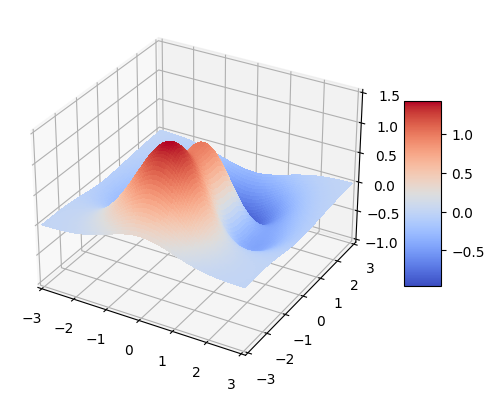

In [237]:
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.axes.set_xlim3d(left=-3, right=3)
ax.axes.set_ylim3d(bottom=-3, top=3)
ax.axes.set_zlim3d(bottom=-1, top=1.5)
surf = ax.plot_surface(x1,x2,y, rstride=1, cstride=1,
                      cmap=cm.coolwarm,linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Retrive initial dataset

In [238]:
n = 10 # Number of training points
train_x1 = torch.rand(n,1)*3
train_x2 = torch.rand(n,1)*3
train_x = torch.stack((train_x1,train_x2),-1).squeeze(1)

train_y = F(train_x1,train_x2)
best_observed = train_y.max().item()
train_x,train_y,best_observed

(tensor([[1.9023, 0.7461],
         [0.2540, 0.1817],
         [0.0964, 1.6439],
         [0.1951, 1.1393],
         [0.9499, 2.5732],
         [1.9499, 2.1612],
         [1.5655, 1.8195],
         [0.0081, 2.8627],
         [1.8247, 1.6423],
         [1.9456, 1.5133]]),
 tensor([[-0.3761],
         [ 0.8852],
         [-0.8896],
         [-0.2650],
         [-0.3937],
         [-0.1865],
         [-0.4193],
         [-0.3731],
         [-0.3320],
         [-0.2997]]),
 0.8852233290672302)

Visualise training points

 /var/folders/tb/pnmvscp95f1247fst_lcrqym0000gn/T/ipykernel_9991/3412711665.py:7: UserWarning:The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'


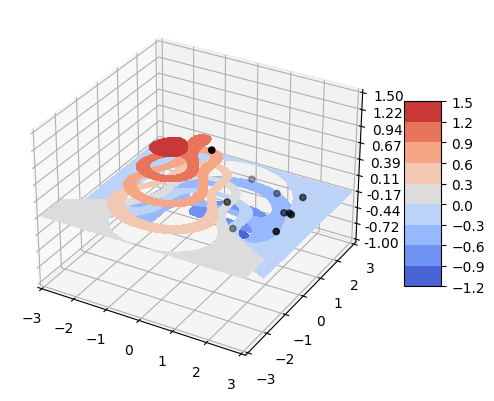

In [239]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.axes.set_xlim3d(left=-3, right=3)
ax.axes.set_ylim3d(bottom=-3, top=3)
ax.axes.set_zlim3d(bottom=-1, top=1.5)

surf = ax.contourf(x1, x2, y, rstride=1, cstride=1,
                      cmap=cm.coolwarm,linewidth=0, antialiased=False) # Objective
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.scatter(train_x1,train_x2,train_y,color='black')

plt.show()

## Fit GP model
Default:
    likelihood: standard Gaussian likelihood with inferred noise level
    Covar_module: Matern kernel
    Mean_module: Constant mean

In [248]:
model = SingleTaskGP(train_x,train_y)
mll = ExactMarginalLogLikelihood(model.likelihood,model)
fit_gpytorch_model(mll)


test_x1 = torch.linspace(0, 10, 101)
test_x2 = torch.linspace(0, 10, 101)
test_x = torch.stack((test_x1,test_x2),-1).squeeze(1)

posterior = model.posterior(test_x)

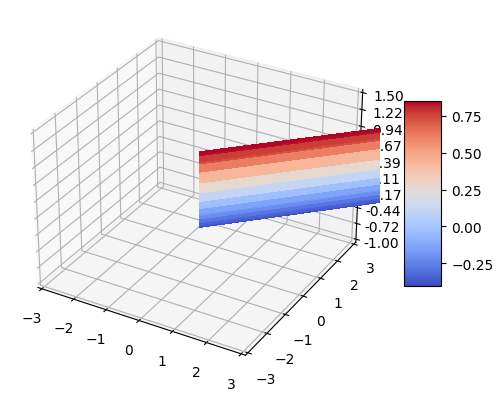

In [249]:
with torch.no_grad():
    # Initialize plot
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    ax.axes.set_xlim3d(left=-3, right=3)
    ax.axes.set_ylim3d(bottom=-3, top=3)
    ax.axes.set_zlim3d(bottom=-1, top=1.5)
    surf = ax.plot_surface(test_x1,test_x2,posterior.mean, rstride=1, cstride=1,
                          cmap=cm.coolwarm,linewidth=0, antialiased=False) # Posterior.mean is the problem here
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

## Fully Bayesian GP Models (High dimensional problems)
Sample a set of hyperparameters from the posterior
Prior: sparse axis-aligned subspace priors (SAAS) model to identify the most important parameters

In [118]:
# saas_gp = SaasFullyBayesianSingleTaskGP(train_x, train_y)
# fit_fully_bayesian_model_nuts(saas_gp)
# posterior = saas_gp.posterior(test_x)

## Acquistion function
Morte-Carlo sampling:
1. Sampling joint posterior over q points
2. evaluate the current best for each sample
3. maximise over q
4. average over the samples

# EI Defaults:
1. Sampler: SobolQMCNormalSampler
2. Objective: IdentityMCObjective() (objective under which samples is evaluated)

In [250]:
EI = qExpectedImprovement(
    model = model,
    best_f = best_observed
)

## Noisy Expected Improvement:
Does not assume best_f, compute improvement over the previous points and average

In [372]:
NEI = qNoisyExpectedImprovement(
    model = model,
    X_baseline = train_x,
    prune_baseline= True,
)

## qUCB
beta: control the tradeoff between mean and variance.

In [374]:
UCB = qUpperConfidenceBound(
    model = model,
    beta = 0.6,
)

## Optimise acquisition function

In [251]:
candidates_x,_ = optimize_acqf(
    acq_function = EI,
    bounds = torch.tensor([[-3.0] * 2, [3.0] * 2]),
    q = 5, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x

candidates_x

tensor([[ 0.3189, -0.0895],
        [ 0.3557,  0.3641],
        [ 0.0573,  0.3212],
        [ 0.5269,  0.1410],
        [ 0.0312,  0.0324]])

In [252]:
candidates_x1 = candidates_x[:,0]
candidates_x2 = candidates_x[:,1]
candidates_x1,candidates_x2

(tensor([0.3189, 0.3557, 0.0573, 0.5269, 0.0312]),
 tensor([-0.0895,  0.3641,  0.3212,  0.1410,  0.0324]))

In [253]:
candidates_y = F(candidates_x1,candidates_x2).unsqueeze(-1)
candidates_y

tensor([[0.8510],
        [0.7249],
        [0.9136],
        [0.6201],
        [0.9980]])

Visualise suggested candidates

 /var/folders/tb/pnmvscp95f1247fst_lcrqym0000gn/T/ipykernel_9991/3064725049.py:7: UserWarning:The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'


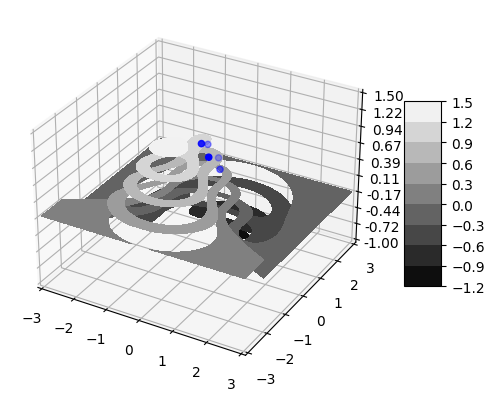

In [254]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.axes.set_xlim3d(left=-3, right=3)
ax.axes.set_ylim3d(bottom=-3, top=3)
ax.axes.set_zlim3d(bottom=-1, top=1.5)

surf = ax.contourf3D(x1, x2, y, rstride=1, cstride=1,
                      cmap=cm.gray,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.scatter(candidates_x1,candidates_x2,candidates_y,color='blue')

plt.show()

In [255]:
# plt.plot(train_x,train_y,'o', color = 'black')
# plt.plot(candidates_x,candidates_y,'*')
# plt.legend(['training points','suggested candidates'])
# plt.plot(x,F(x))
# plt.show()

## Take in suggested data, forming new training dataset

In [257]:
combine_x = (train_x,candidates_x)
combine_y = (train_y,candidates_y)
posterior_x = torch.cat(combine_x, dim = 0)
posterior_y = torch.cat(combine_y, dim = 0)
posterior_x,posterior_y

(tensor([[ 1.9023,  0.7461],
         [ 0.2540,  0.1817],
         [ 0.0964,  1.6439],
         [ 0.1951,  1.1393],
         [ 0.9499,  2.5732],
         [ 1.9499,  2.1612],
         [ 1.5655,  1.8195],
         [ 0.0081,  2.8627],
         [ 1.8247,  1.6423],
         [ 1.9456,  1.5133],
         [ 0.3189, -0.0895],
         [ 0.3557,  0.3641],
         [ 0.0573,  0.3212],
         [ 0.5269,  0.1410],
         [ 0.0312,  0.0324]]),
 tensor([[-0.3761],
         [ 0.8852],
         [-0.8896],
         [-0.2650],
         [-0.3937],
         [-0.1865],
         [-0.4193],
         [-0.3731],
         [-0.3320],
         [-0.2997],
         [ 0.8510],
         [ 0.7249],
         [ 0.9136],
         [ 0.6201],
         [ 0.9980]]))

## Posterior model (Not sure how to plot contour yet)

In [258]:
posterior_model = SingleTaskGP(posterior_x,posterior_y,)
mll = ExactMarginalLogLikelihood(posterior_model.likelihood,model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [259]:
# # Plot
# posterior_model.eval()
# # Initialize plot
# f, ax = plt.subplots(1, 1, figsize=(6, 4))
# # test model on 101 regular spaced points on the interval [0, 10]
# test_x = torch.linspace(0, 10, 101)
# # no need for gradients
# with torch.no_grad():
#     # compute posterior
#     posterior = posterior_model.posterior(test_x)
#     # Get upper and lower confidence bounds (2 standard deviations from the mean)
#     lower, upper = posterior.mvn.confidence_region()
#     # Plot training points as black stars
#     ax.plot(posterior_x.cpu().numpy(), posterior_y.cpu().numpy(), 'o',)
#     # Plot posterior means as blue line
#     ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
#     # Shade between the lower and upper confidence bounds
#     ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
#     plt.plot(x,F(x))
# ax.legend(['Observed Data', 'Mean', 'Confidence'])
# plt.tight_layout()
# plt.show()

## Second run

In [260]:
EI = qExpectedImprovement(
    model = posterior_model,
    best_f = best_observed
)

In [261]:
candidates_x,_ = optimize_acqf(
    acq_function = EI,
    bounds = torch.tensor([[-3.0] * 2, [3.0] * 2]),
    q = 10, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x

tensor([[-0.5728,  0.1921],
        [-3.0000, -3.0000],
        [ 1.2753, -1.1014],
        [-0.8111, -3.0000],
        [-1.4149, -0.1612],
        [ 3.0000, -3.0000],
        [-3.0000,  3.0000],
        [-3.0000, -0.0246],
        [-0.3317, -0.5213],
        [ 0.2459, -1.0239]])

In [262]:
candidates_x1 = candidates_x[:,0]
candidates_x2 = candidates_x[:,1]
candidates_x1,candidates_x2

(tensor([-0.5728, -3.0000,  1.2753, -0.8111, -1.4149,  3.0000, -3.0000, -3.0000,
         -0.3317,  0.2459]),
 tensor([ 0.1921, -3.0000, -1.1014, -3.0000, -0.1612, -3.0000,  3.0000, -0.0246,
         -0.5213, -1.0239]))

In [263]:
candidates_y = F(candidates_x1,candidates_x2).unsqueeze(-1)
candidates_y

tensor([[ 0.5539],
        [ 0.0023],
        [ 0.1717],
        [ 0.2186],
        [-0.3619],
        [ 0.0023],
        [-0.0043],
        [-0.0888],
        [ 0.8523],
        [ 1.1562]])

 /var/folders/tb/pnmvscp95f1247fst_lcrqym0000gn/T/ipykernel_9991/3339552765.py:7: UserWarning:The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'


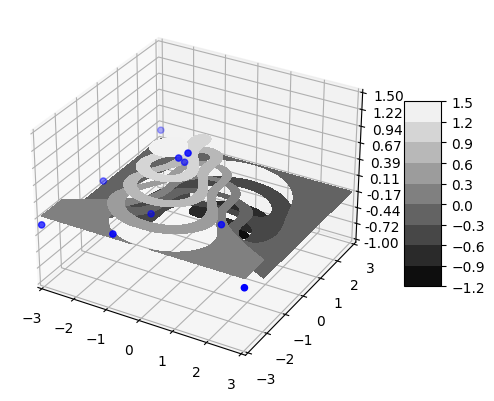

In [264]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.axes.set_xlim3d(left=-3, right=3)
ax.axes.set_ylim3d(bottom=-3, top=3)
ax.axes.set_zlim3d(bottom=-1, top=1.5)

surf = ax.contourf3D(x1, x2, y, rstride=1, cstride=1,
                      cmap=cm.gray,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.scatter(candidates_x1,candidates_x2,candidates_y,color='blue')

plt.show()